MASSACHUSETTS INSTITUTE OF TECHNOLOGY<br>
SYSTEM DESIGN & MANAGEMENT<br>
Author: R. Chadwick Holmes<br>
Date: March 22, 2021<br>
Last Updated: December 8, 2021<br><br>

**Label: Final Workflow, Script 3**<br>

Script Purpose:<br>
Script for exploring supervised learning applied to the data set and the impact of uncertainties.
<br><br>


In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Dec 10 03:29:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!apt update
!apt upgrade
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes cartopy
!pip uninstall -y shapely
!pip install shapely --no-binary shapely
!pip install dataprep --no-binary dataprep

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:14 

In [3]:
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV, Lasso
from sklearn.model_selection import GridSearchCV, cross_val_score, RepeatedKFold, RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, PowerTransformer, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn import tree

from sklearn.metrics import roc_auc_score

from collections import Counter

import statsmodels.api as sm
from scipy import stats

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
import pickle as pkl

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [20]:
import geopandas as gpd  # combines the capabilities of pandas and shapely for geospatial operations
from shapely.geometry import Point, Polygon, MultiPolygon  # for manipulating text data into geospatial shapes
from shapely import wkt  # stands for "well known text," allows for interchange across GIS programs
import rtree  # supports geospatial join

import matplotlib as mpl 
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap

import seaborn as sns

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

### Set seed for randomized elements in script

In [5]:
seed = 43

# define extent for mapping
xmin,xmax,ymin,ymax = [-109.1, -105.9, 31.3, 35.4]
extent = [xmin,xmax,ymin,ymax]

### Mount Google Drive

In [7]:
from google.colab import drive
drive.mount('/content/drive')
path = r'/content/drive/MyDrive/Colab Notebooks/Data'

Mounted at /content/drive


### Helper Functions

In [8]:
import matplotlib.pyplot as plt

## Set Plotting Parameters
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [9]:
myprojection = ccrs.PlateCarree()

def createBasemap():
    expl_area = datafolder / 'Exploration_area.shp'
    expl_area_feat = ShapelyFeature(Reader(expl_area).geometries(), crs=myprojection, edgecolor='black')

    rivers_50m = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '50m')
    ##stamen_terrain = cimgt.Stamen('terrain-background')

    # generate plot of NM with river and stock image
    plt.figure(figsize=(20,12))
    ax = plt.axes(projection=myprojection)

    # Add the Stamen data at zoom level 9.
    ax.stock_img()
    #ax.add_image(stamen_terrain, 9)
    
    ax.add_feature(cartopy.feature.STATES)
    ax.add_feature(rivers_50m, facecolor='None', edgecolor='b')
    ax.add_feature(expl_area_feat, facecolor='None', edgecolor='r', linewidth=2, alpha = 0.5)

    ax.set_extent(extent,crs=myprojection)
    
    return ax

### Load data from saved pickle file

In [10]:
datafolder = Path(path) 

#with open(datafolder/ "wellsp8_shared.pkl","rb") as handle: 
with open(datafolder/ "wellsp4_shared.pkl","rb") as handle: 
#with open(datafolder/ "wells_shared.pkl","rb") as handle: 
    datadict = pkl.load(handle)
    
# unpack
fulldf = datadict['data']
coords = datadict['coords']
X_train = datadict['X_train'].reset_index(drop=True)
X_val   = datadict['X_val'].reset_index(drop=True)
X_test  = datadict['X_test'].reset_index(drop=True)
yr_train = datadict['yr_train'].reset_index(drop=True)
yr_val   = datadict['yr_val'].reset_index(drop=True)
yr_test  = datadict['yr_test'].reset_index(drop=True)
yc_train = datadict['yc_train'].reset_index(drop=True)
yc_val   = datadict['yc_val'].reset_index(drop=True)
yc_test  = datadict['yc_test'].reset_index(drop=True)

In [11]:
print(X_train.shape)
X_train.head(2)

(2081, 26)


,DEM,DEMGrad,Gravity,GravityGrad,Magnetic,MagneticGrad,DosageRate,WTDepth,WTGrad,BasementDepth,CrustalThickness,AirTemperature,Precipitation,StrainRate,QFaults,StateFaults,Drainage,VolcanicDikes,SiGeothermometry,Lithium,Boron,HeatFlow,Earthquakes,Vents,Springs,GeothermGrad_2class
0,1295.000000,0.000950,-142.761505,0.105854,-176.388245,1.689665,54.990135,414.932678,101982.015625,3668.409912,27.983309,16.552637,250.675491,0.944725,12.385615,13.238408,3.962933,0.000000,46.190140,0.135530,0.509297,86.209236,-28.222088,-24.506508,-28.341091,"[0, 60)"
1,1280.403809,4.268405,-140.713547,0.053293,-130.635025,2.623726,63.302460,271.751038,598030.937500,4062.800293,27.660280,16.698074,265.794037,1.301721,5.504663,6.772988,7.627896,0.002682,80.419975,0.433037,0.349059,121.289711,-26.203899,-26.080971,-26.779902,"[60, 9999)"


## Test that plotting works

/usr/local/lib/python3.7/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_1_states_provinces_lakes.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/usr/local/lib/python3.7/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/50m/physical/ne_50m_rivers_lake_centerlines.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


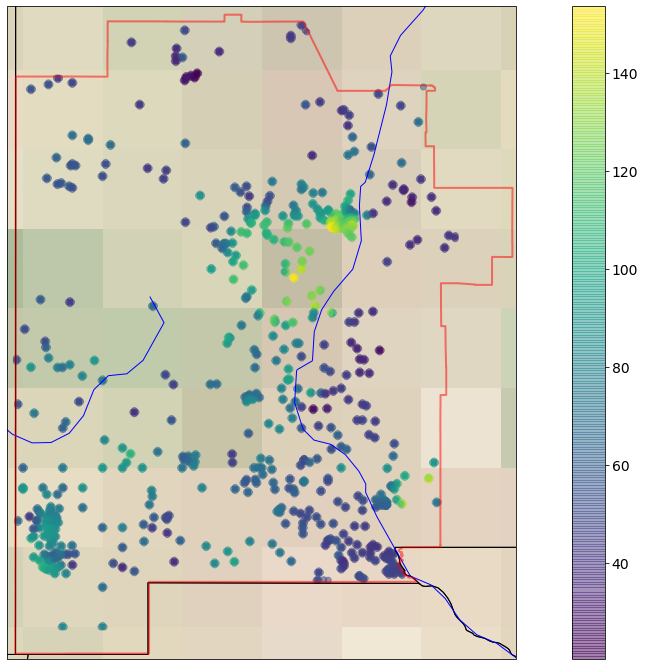

In [12]:
ax = createBasemap();

gdf = gpd.GeoDataFrame(fulldf.copy(deep=True), 
                       geometry=gpd.points_from_xy(coords.Longitude, coords.Latitude),
                       crs = {'init': 'epsg:4326'})
pc = ax.scatter(coords.Longitude,
                coords.Latitude,
                cmap='viridis',
                c=gdf['DosageRate'],
                #c=gdf['CutCategory'].cat.codes,
                #vmin=0, vmax=125,
                alpha=0.5,
                transform=myprojection);
plt.colorbar(pc);

## Decision Tree Classifier
### Use 4-class model based on cut-offs defined in literature
### Dropping AirTemperature

In [13]:
dropcols = ['AirTemperature','GeothermGrad_2class'] 

# use original data set (imbalanced)
Xtr = X_train.drop(dropcols,axis=1)
Xvl = X_val.drop(dropcols,axis=1)
Xts = X_test.drop(dropcols,axis=1)

# scale and transform data
# note: using StandardScaler + PowerTransformer due to bug found in PowerTransformer with standard=True alone
# i.e., it converts DEM and Precipitation to single value features
sc = StandardScaler()
pt = PowerTransformer(method='yeo-johnson',standardize=True)
pl = Pipeline(steps=[('scale',sc),('powertransform',pt)])

colnames = [x for x in Xtr.columns if x not in dropcols]
print(colnames)
pl.fit(Xtr[colnames],yc_train)
Xtrsc = pd.DataFrame(pl.transform(Xtr[colnames]), columns=colnames)
Xvlsc = pd.DataFrame(pl.transform(Xvl[colnames]), columns=colnames)
Xtssc = pd.DataFrame(pl.transform(Xts[colnames]), columns=colnames)

# 4-class model once multi-class methods are ready
yc_val4   = yc_val['GeothermGrad_4class'].cat.codes
yc_test4  = yc_test['GeothermGrad_4class'].cat.codes
yc_train4 = yc_train['GeothermGrad_4class'].cat.codes

['DEM', 'DEMGrad', 'Gravity', 'GravityGrad', 'Magnetic', 'MagneticGrad', 'DosageRate', 'WTDepth', 'WTGrad', 'BasementDepth', 'CrustalThickness', 'Precipitation', 'StrainRate', 'QFaults', 'StateFaults', 'Drainage', 'VolcanicDikes', 'SiGeothermometry', 'Lithium', 'Boron', 'HeatFlow', 'Earthquakes', 'Vents', 'Springs']


In [14]:
# encode classification variable
le = LabelEncoder()
le.fit(yc_train4)
yenc_trn = le.transform(yc_train4)
yenc_val = le.transform(yc_val4)
yenc_tst = le.transform(yc_test4)

Xtrvl = pd.concat([Xtr[colnames],Xvl[colnames]])
Xtrnvalsc=pd.concat([Xtrsc[colnames],Xvlsc[colnames]])
yenc_trnval=np.append(yenc_trn,yenc_val)

In [15]:
print('train:')
counter = Counter(yc_train4)
for k,v in counter.items():
	per = v / len(yc_train4) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
 
print('\nvalidate:')
counter = Counter(yc_val4)
for k,v in counter.items():
	per = v / len(yc_val4) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

print('\ntest:')
counter = Counter(yc_test4)
for k,v in counter.items():
	per = v / len(yc_test4) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

#print(list(Xtr))

train:
Class=2, n=801 (38.491%)
Class=3, n=860 (41.326%)
Class=1, n=349 (16.771%)
Class=0, n=71 (3.412%)

validate:
Class=2, n=171 (38.341%)
Class=3, n=185 (41.480%)
Class=1, n=75 (16.816%)
Class=0, n=15 (3.363%)

test:
Class=3, n=184 (41.256%)
Class=2, n=172 (38.565%)
Class=1, n=75 (16.816%)
Class=0, n=15 (3.363%)


### Hyperparameter Tuning

#### Max Depth & Criterion

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
import matplotlib as mpl

# maintain stratified sampling
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed)

# include scaling and transformations as part of model pipeline
# as noted earlier, StandardScaler and PowerTransformer both used to standardize
# to overcome bug that reduces 2 features to single values
sc = StandardScaler()
pt = PowerTransformer(method='yeo-johnson',standardize=True)

# decision tree
dtree = DecisionTreeClassifier(random_state=seed)

# pipeline for scaling and training
pipeline = Pipeline([('scale',sc),('powertransform',pt),('decisiontree',dtree)])

# Setup the parameters and distributions to sample from: param_dist
param_grid = {'decisiontree__max_depth': np.arange(2,15),
              'decisiontree__criterion': ['gini', 'entropy']}

# grid search for best parameters
dtree_cv = GridSearchCV(pipeline, 
                        param_grid, 
                        n_jobs=-1, 
                        cv=cv, 
                        verbose=1, 
                        scoring='roc_auc_ovr', 
                        refit=True)

# Fit it to the data
#dtree_cv.fit(Xtr[colnames],yenc_trn)
dtree_cv.fit(Xtrvl[colnames],yenc_trnval)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(dtree_cv.best_params_))
print("Best score is {}".format(dtree_cv.best_score_))
print("Validation score is {}".format(dtree_cv.best_estimator_.score(Xvl[colnames],yenc_val)))
print("Test score is {}".format(dtree_cv.best_estimator_.score(Xts[colnames],yenc_tst)))

best_params = {'criterion':dtree_cv.best_params_['decisiontree__criterion'],
               'max_depth':dtree_cv.best_params_['decisiontree__max_depth']}
best_params

Fitting 30 folds for each of 26 candidates, totalling 780 fits
Tuned Decision Tree Parameters: {'decisiontree__criterion': 'entropy', 'decisiontree__max_depth': 9}
Best score is 0.9422533610374108
Validation score is 0.9282511210762332
Test score is 0.8923766816143498


{'criterion': 'entropy', 'max_depth': 9}

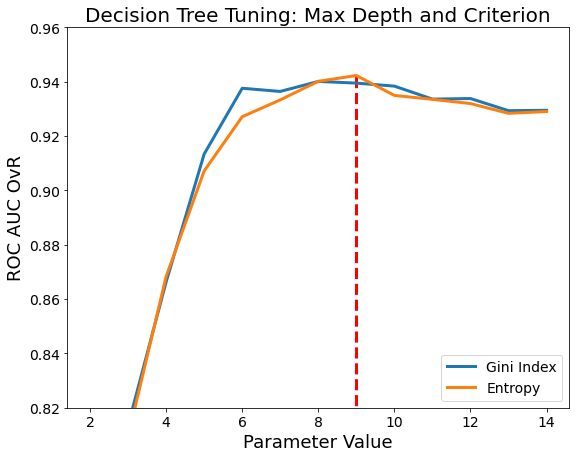

In [ ]:
with mpl.style.context('seaborn-muted'):
  plt.figure(figsize=(9,7))
  plt.plot(np.arange(2,15),
           dtree_cv.cv_results_['mean_test_score'][0:13],
           c='#1F77B4',lw=3,label='Gini Index')
  plt.plot(np.arange(2,15),
           dtree_cv.cv_results_['mean_test_score'][13:],
           c='#FF7F0E',lw=3,label='Entropy');
  plt.vlines(best_params['max_depth'],ymin=.78,ymax=dtree_cv.best_score_,
             linestyles='dashed',colors='r',lw=3)
  plt.ylim([0.82,0.96])
  plt.legend(loc='lower right')
  plt.title('Decision Tree Tuning: Max Depth and Criterion');
  plt.ylabel('ROC AUC OvR');
  plt.xlabel('Parameter Value');

#### Min Samples Leaf

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

# maintain stratified sampling
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed)

# scale and transform data on the fly
sc = StandardScaler()
pt = PowerTransformer(method='yeo-johnson',standardize=True)

# decision tree
dtree = DecisionTreeClassifier(criterion=best_params['criterion'],
                               max_depth=best_params['max_depth'],
                               random_state=seed)

# pipeline for scaling and training
pipeline = Pipeline([('scale',sc),('powertransform',pt),('decisiontree',dtree)])

# Setup the parameters and distributions to sample from: param_dist
param_grid = {'decisiontree__min_samples_leaf': range(2,15)}

# grid search for best parameters
dtree_cv = GridSearchCV(pipeline, 
                        param_grid, 
                        n_jobs=-1, 
                        cv=cv, 
                        verbose=1, 
                        scoring='roc_auc_ovr', 
                        refit=True)
# Fit it to the data
dtree_cv.fit(Xtrvl[colnames],yenc_trnval)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(dtree_cv.best_params_))
print("Best score is {}".format(dtree_cv.best_score_))
print("Validation score is {}".format(dtree_cv.best_estimator_.score(Xvl[colnames],yenc_val)))
print("Test score is {}".format(dtree_cv.best_estimator_.score(Xts[colnames],yenc_tst)))

best_params['min_samples_leaf'] = dtree_cv.best_params_['decisiontree__min_samples_leaf']
best_params

Fitting 30 folds for each of 13 candidates, totalling 390 fits
Tuned Decision Tree Parameters: {'decisiontree__min_samples_leaf': 7}
Best score is 0.9536886661906078
Validation score is 0.9103139013452914
Test score is 0.8587443946188341


{'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 7}

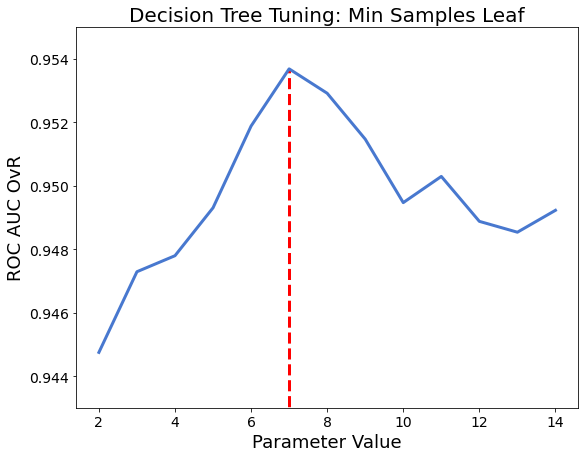

In [ ]:
with mpl.style.context('seaborn-muted'):
  plt.figure(figsize=(9,7))
  plt.plot(range(2,15), dtree_cv.cv_results_['mean_test_score'],lw=3)
  plt.vlines(best_params['min_samples_leaf'],ymin=.9345,lw=3,
             ymax=dtree_cv.best_score_,linestyles='dashed',colors='r')
  plt.ylim([0.943,0.955])
  plt.title('Decision Tree Tuning: Min Samples Leaf');
  plt.ylabel('ROC AUC OvR');
  plt.xlabel('Parameter Value');

#### Min Samples Split

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

# maintain stratified sampling
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed)

# scale and transform data on the fly
sc = StandardScaler()
pt = PowerTransformer(method='yeo-johnson',standardize=True)

# decision tree
dtree = DecisionTreeClassifier(criterion=best_params['criterion'],
                               max_depth=best_params['max_depth'],
                               min_samples_leaf=best_params['min_samples_leaf'],
                               random_state=seed)

# pipeline for scaling and training
pipeline = Pipeline([('scale',sc),('powertransform',pt),('decisiontree',dtree)])

# Setup the parameters and distributions to sample from: param_dist
param_grid = {'decisiontree__min_samples_split': range(2*best_params['min_samples_leaf']+1,25)}

# grid search for best parameters
dtree_cv = GridSearchCV(pipeline, 
                        param_grid, 
                        n_jobs=-1, 
                        cv=cv, 
                        verbose=1, 
                        scoring='roc_auc_ovr', 
                        refit=True)
# Fit it to the data
dtree_cv.fit(Xtrvl[colnames],yenc_trnval)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(dtree_cv.best_params_))
print("Best score is {}".format(dtree_cv.best_score_))
print("Validation score is {}".format(dtree_cv.best_estimator_.score(Xvl[colnames],yenc_val)))
print("Test score is {}".format(dtree_cv.best_estimator_.score(Xts[colnames],yenc_tst)))

best_params['min_samples_split'] = dtree_cv.best_params_['decisiontree__min_samples_split']
best_params

Fitting 30 folds for each of 10 candidates, totalling 300 fits
Tuned Decision Tree Parameters: {'decisiontree__min_samples_split': 18}
Best score is 0.9527384815642796
Validation score is 0.9080717488789237
Test score is 0.8452914798206278


{'criterion': 'entropy',
 'max_depth': 9,
 'min_samples_leaf': 7,
 'min_samples_split': 18}

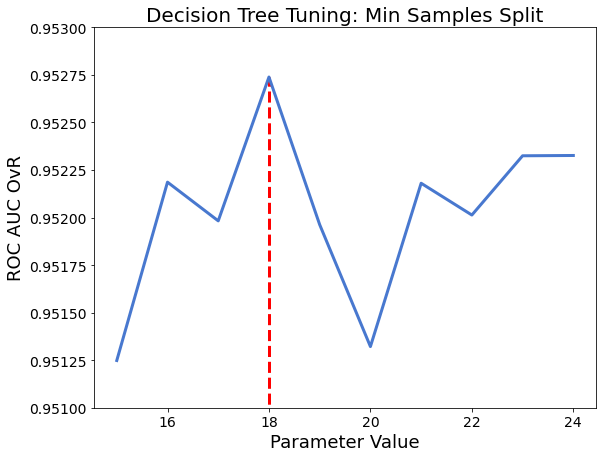

In [ ]:
with mpl.style.context('seaborn-muted'):
  plt.figure(figsize=(9,7))
  plt.plot(range(2*best_params['min_samples_leaf']+1,25), dtree_cv.cv_results_['mean_test_score'],lw=3)
  plt.vlines(dtree_cv.best_params_['decisiontree__min_samples_split'],lw=3,
             ymin=.945,ymax=dtree_cv.best_score_,linestyles='dashed',colors='r')
  plt.ylim([0.951,0.953])
  plt.title('Decision Tree Tuning: Min Samples Split');
  plt.ylabel('ROC AUC OvR');
  plt.xlabel('Parameter Value');

#### Max Features

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

# maintain stratified sampling
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed)

# scale and transform data on the fly
sc = StandardScaler()
pt = PowerTransformer(method='yeo-johnson',standardize=True)

# decision tree
dtree = DecisionTreeClassifier(criterion=best_params['criterion'],
                               max_depth=best_params['max_depth'],
                               min_samples_leaf=best_params['min_samples_leaf'],
                               min_samples_split=best_params['min_samples_split'],
                               random_state=seed)

# pipeline for scaling and training
pipeline = Pipeline([('scale',sc),('powertransform',pt),('decisiontree',dtree)])

# Setup the parameters and distributions to sample from: param_dist
param_grid = {'decisiontree__max_features': range(1,25,1)}

# grid search for best parameters
dtree_cv = GridSearchCV(pipeline, 
                        param_grid, 
                        n_jobs=-1, 
                        cv=cv, 
                        verbose=1, 
                        scoring='roc_auc_ovr', 
                        refit=True)
# Fit it to the data
dtree_cv.fit(Xtrvl[colnames],yenc_trnval)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(dtree_cv.best_params_))
print("Best score is {}".format(dtree_cv.best_score_))
print("Validation score is {}".format(dtree_cv.best_estimator_.score(Xvl[colnames],yenc_val)))
print("Test score is {}".format(dtree_cv.best_estimator_.score(Xts[colnames],yenc_tst)))

best_params['max_features'] = dtree_cv.best_params_['decisiontree__max_features']
best_params

Fitting 30 folds for each of 24 candidates, totalling 720 fits
Tuned Decision Tree Parameters: {'decisiontree__max_features': 20}
Best score is 0.9546057161108953
Validation score is 0.9282511210762332
Test score is 0.8385650224215246


{'criterion': 'entropy',
 'max_depth': 9,
 'max_features': 20,
 'min_samples_leaf': 7,
 'min_samples_split': 18}

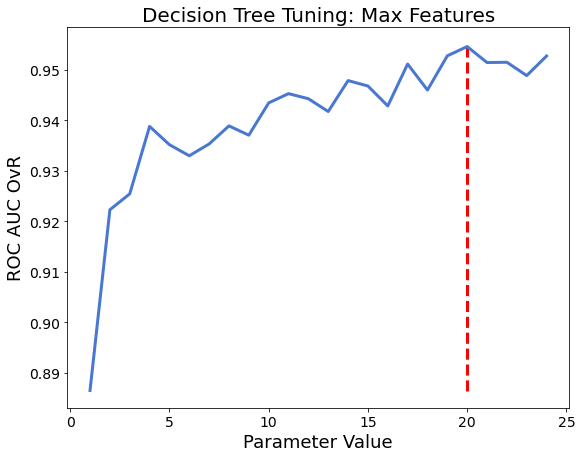

In [ ]:
with mpl.style.context('seaborn-muted'):
  plt.figure(figsize=(9,7))
  plt.plot(range(1,25,1), dtree_cv.cv_results_['mean_test_score'],lw=3) #marker='o',
  plt.vlines(best_params['max_features'],
             ymin=min(dtree_cv.cv_results_['mean_test_score']), 
             ymax=0.955,
             linestyles='dashed',colors='r',lw=3)
  #plt.ylim([0.88,0.96])
  plt.title('Decision Tree Tuning: Max Features');
  plt.ylabel('ROC AUC OvR');
  plt.xlabel('Parameter Value');

In [ ]:
## Max Features is problematic as RFE is used
#best_params['max_features'] = None

#### Check tuning results

In [16]:
RESET_BEST_PARAMS = True
VERSION = 4

if RESET_BEST_PARAMS:
  if VERSION == 4:
    best_params = {'criterion': 'entropy', 
                   'max_depth': 9, 
                   'min_samples_leaf': 7, 
                   'min_samples_split': 18, 
                   'max_features': 20,
                   'ccp_alpha': 0.01
                   }
  elif VERSION == 8:
     best_params = {'criterion': 'entropy', 
                   'max_depth': 10, 
                   'min_samples_leaf': 8, 
                   'min_samples_split': 23, 
                   'max_features': 17,
                   'ccp_alpha': 0.005
                   }  
  else:
     best_params = {'criterion': 'gini', 
                   'max_depth': 5, 
                   'min_samples_leaf': 7, 
                   'min_samples_split': 21, 
                   'max_features': 17,
                   'ccp_alpha': 0.02
                   }  

In [17]:
best_params

{'ccp_alpha': 0.01,
 'criterion': 'entropy',
 'max_depth': 9,
 'max_features': 20,
 'min_samples_leaf': 7,
 'min_samples_split': 18}

In [18]:
scorediff,roctestvals = list(),list()
for alpha in np.arange(0,10,.5):
  print('alpha={}'.format(alpha))
  mod_dt = DecisionTreeClassifier(criterion=best_params['criterion'],
                                  max_depth=best_params['max_depth'],
                                  min_samples_leaf=best_params['min_samples_leaf'],
                                  min_samples_split=best_params['min_samples_split'],
                                  max_features=best_params['max_features'],
                                  ccp_alpha=alpha/100,
                                  random_state=seed)
  sc = StandardScaler()
  pt = PowerTransformer(method='yeo-johnson', standardize=True)
  pipeline = Pipeline(steps=[('scale',sc),('powertransform',pt),('dtree',mod_dt)])
  pipeline.fit(Xtr[colnames], yenc_trn)

  roctrn = roc_auc_score(yenc_trn,
                        pipeline.predict_proba(Xtr),
                        multi_class='ovr')
  print('roc_auc_ovr train: {}'.format(roctrn))
    
  rocval = roc_auc_score(yenc_val,
                        pipeline.predict_proba(Xvl),
                        multi_class='ovr')
  print('roc_auc_ovr validation: {}'.format(rocval))
  
  scorediff.append(roctrn-rocval)
  roctestvals.append(rocval)

alpha=0.0
roc_auc_ovr train: 0.9877479234388962
roc_auc_ovr validation: 0.9606031675393717
alpha=0.5
roc_auc_ovr train: 0.9850868386125867
roc_auc_ovr validation: 0.9662852324180158
alpha=1.0
roc_auc_ovr train: 0.9714151566615368
roc_auc_ovr validation: 0.9578261295475217
alpha=1.5
roc_auc_ovr train: 0.9475092912867549
roc_auc_ovr validation: 0.9335374232743532
alpha=2.0
roc_auc_ovr train: 0.9351815604884902
roc_auc_ovr validation: 0.921289897572121
alpha=2.5
roc_auc_ovr train: 0.9247508110601395
roc_auc_ovr validation: 0.9085359598385578
alpha=3.0
roc_auc_ovr train: 0.9124089654136907
roc_auc_ovr validation: 0.8998558841403675
alpha=3.5
roc_auc_ovr train: 0.8187556608889164
roc_auc_ovr validation: 0.8376975692299413
alpha=4.0
roc_auc_ovr train: 0.8187556608889164
roc_auc_ovr validation: 0.8376975692299413
alpha=4.5
roc_auc_ovr train: 0.8187556608889164
roc_auc_ovr validation: 0.8376975692299413
alpha=5.0
roc_auc_ovr train: 0.8187556608889164
roc_auc_ovr validation: 0.8376975692299413


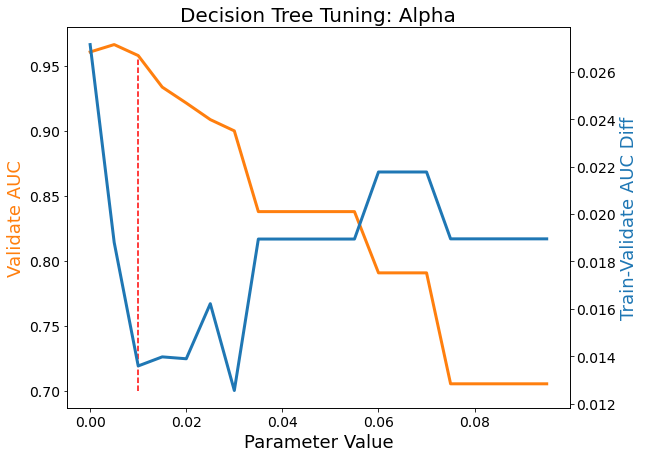

In [21]:
with mpl.style.context('seaborn-muted'):
  fig, ax1 = plt.subplots(figsize=(9,7))
  
  ax1.plot(np.arange(0,10,.5)/100,roctestvals, lw=3, 
           label='Normalized Test AUC', c='#FF7F0E')
  ax2 = ax1.twinx()
  ax2.plot(np.arange(0,10,.5)/100,np.abs(scorediff), lw=3,
           label='Normalized Train-Test AUC Difference',
           color='#1F77B4') 
  
  ax1.set_xlabel('Parameter Value');
  ax1.set_ylabel('Validate AUC', color='#FF7F0E')
  ax2.set_ylabel('Train-Validate AUC Diff',color='#1F77B4')
  ax1.vlines(0.01, ymin=0.7, ymax=0.955,linestyles='dashed',colors='r')
  plt.title('Decision Tree Tuning: Alpha');
  #plt.legend(loc='best')
  
  best_params['ccp_alpha'] = 0.01

In [27]:
mod_dt = DecisionTreeClassifier(criterion=best_params['criterion'],
                                  max_depth=best_params['max_depth'],
                                  min_samples_leaf=best_params['min_samples_leaf'],
                                  min_samples_split=best_params['min_samples_split'],
                                  max_features=best_params['max_features'],
                                  ccp_alpha=best_params['ccp_alpha'],
                                  random_state=seed)
sc = StandardScaler()
pt = PowerTransformer(method='yeo-johnson', standardize=True)
pl = Pipeline(steps=[('scale',sc),('powertransform',pt),('dtree',mod_dt)])
pl.fit(Xtrvl[colnames], yenc_trnval)


acctrnval = metrics.accuracy_score(yenc_trnval, pl.predict(Xtrvl))
roctrnval = roc_auc_score(yenc_trnval,
                          pl.predict_proba(Xtrvl),
                          multi_class='ovr')
print('acc_ovr trainval: {} roc_auc_ovr train: {}'.format(acctrnval,roctrnval))
  
acctest = metrics.accuracy_score(yenc_tst, pl.predict(Xts))
roctest = roc_auc_score(yenc_tst,
                        pl.predict_proba(Xts),
                        multi_class='ovr')
print('acc_ovr test: {} roc_auc_ovr test: {}'.format(acctest,roctest))

print(best_params)

acc_ovr trainval: 0.8666402849228334 roc_auc_ovr train: 0.9704151957643702
acc_ovr test: 0.8183856502242153 roc_auc_ovr test: 0.9486616822894689
{'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 7, 'min_samples_split': 18, 'max_features': 20, 'ccp_alpha': 0.01}


In [31]:
fimp = pd.DataFrame({'importance':pl.named_steps.dtree.feature_importances_},index=colnames)
fimp = fimp.sort_values(by='importance',ascending=True)
fimp.to_csv(datafolder / 'dt_importances_wds4.csv')

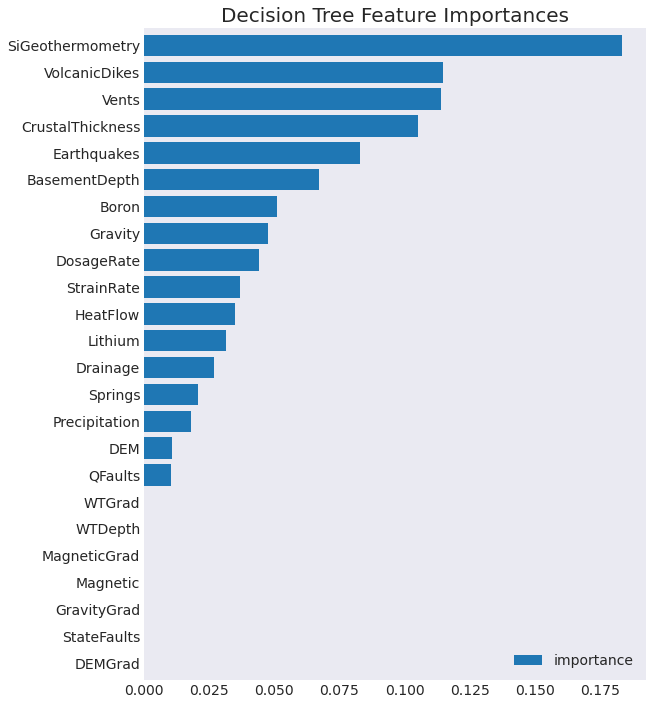

In [ ]:
# plot feature importances
import matplotlib as mpl
with mpl.style.context('seaborn-dark'):
  fimp.plot.barh(stacked=True,width=0.8,figsize=(9,12),rot=0)
  plt.legend(loc='lower right')
  plt.title('Decision Tree Feature Importances');

In [47]:
fimp0 = pd.read_csv(datafolder / 'dt_importances_wds.csv')
fimp0.columns = ['Feature','importance']
fimp4 = pd.read_csv(datafolder / 'dt_importances_wds4.csv')
fimp4.columns = ['Feature','importance']
fimp8 = pd.read_csv(datafolder / 'dt_importances_wds8.csv')
fimp8.columns = ['Feature','importance']

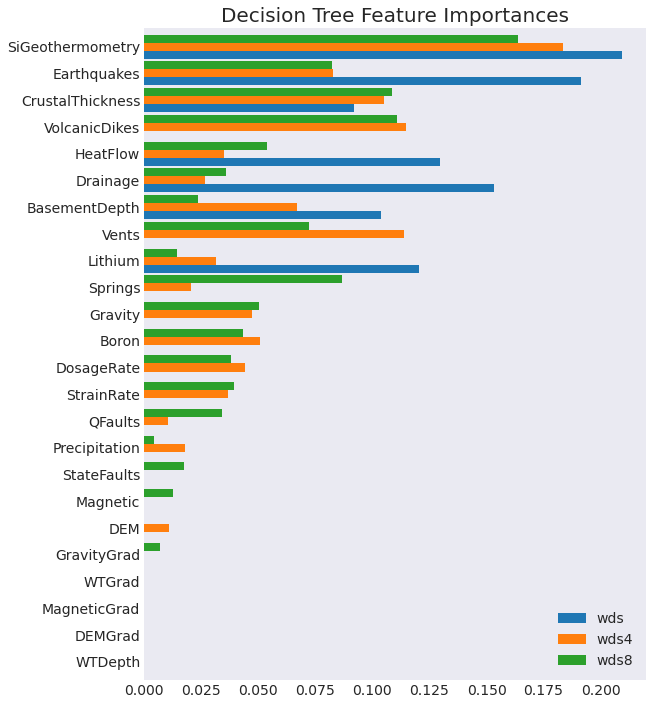

In [58]:
# build cumulative feature plot
mergeddf = pd.merge(pd.merge(fimp0,fimp4,on='Feature'),fimp8,on='Feature')
mergeddf.columns = ['features','wds','wds4','wds8']

mergeddf.set_index('features',inplace=True)
mergeddf['total'] = mergeddf.apply(sum, axis=1)
mergeddf = mergeddf.sort_values(by='total',ascending=True).drop('total',axis=1)

with mpl.style.context('seaborn-dark'):
  mergeddf.plot.barh(width=.9,figsize=(9,12))
  plt.legend(loc='lower right')
  plt.title('Decision Tree Feature Importances');
  plt.ylabel('')

In [59]:
cols2drop = ['MagneticGrad', 'DEMGrad', 'WTDepth', 'WTGrad'] # based on all 3 data sets (combo plot above)
fs_colnames = [c for c in colnames if c not in cols2drop]
print(len(fs_colnames),fs_colnames)

20 ['DEM', 'Gravity', 'GravityGrad', 'Magnetic', 'DosageRate', 'BasementDepth', 'CrustalThickness', 'Precipitation', 'StrainRate', 'QFaults', 'StateFaults', 'Drainage', 'VolcanicDikes', 'SiGeothermometry', 'Lithium', 'Boron', 'HeatFlow', 'Earthquakes', 'Vents', 'Springs']


### Plot ROCs

In [63]:
# refit final pipeline
mod_dt = DecisionTreeClassifier(criterion=best_params['criterion'],
                                max_depth=best_params['max_depth'],
                                min_samples_leaf=best_params['min_samples_leaf'],
                                min_samples_split=best_params['min_samples_split'],
                                max_features=best_params['max_features'],
                                ccp_alpha=best_params['ccp_alpha'],
                                random_state=seed)
sc = StandardScaler()
pt = PowerTransformer(method='yeo-johnson', standardize=True)
finDTpl= Pipeline(steps=[('scaler',sc),('powertransform',pt),('dtree',mod_dt)])

finDTpl.fit(Xtrvl[fs_colnames], yenc_trnval);


Model Results
Accuracy (Train) : 0.8664
Accuracy (Test)  : 0.8139
F1-weighted (Train): 0.866723
F1-weighted (Test) : 0.814628
macro AUC (Train): 0.972428
weighted AUC (Train): 0.965845
macro AUC (Test) : 0.949899
weighted AUC (Test): 0.942928
[[  9   6   0   0]
 [  0  52  16   7]
 [  0  19 142  11]
 [  0   2  22 160]]
              precision    recall  f1-score   support

       No-GT       1.00      0.60      0.75        15
      Low-GT       0.66      0.69      0.68        75
      Med-GT       0.79      0.83      0.81       172
     High-GT       0.90      0.87      0.88       184

    accuracy                           0.81       446
   macro avg       0.84      0.75      0.78       446
weighted avg       0.82      0.81      0.81       446



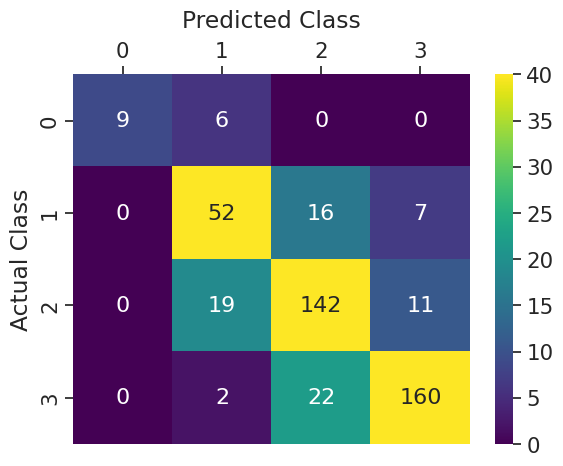

<Figure size 640x480 with 0 Axes>

In [65]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score

mod = finDTpl
xtrn = Xtr[fs_colnames]
ytrn = yenc_trn
xtst = Xts[fs_colnames]
ytst = yenc_tst

# predict
predprobs = mod.predict_proba(xtrn)
preds     = np.argmax(predprobs, axis=1)
predprobs_test = mod.predict_proba(xtst)
preds_test     = np.argmax(predprobs_test, axis=1)

# print stats
print("\nModel Results")
print("Accuracy (Train) : %.4g" % metrics.accuracy_score(ytrn, preds))
print("Accuracy (Test)  : %.4g" % metrics.accuracy_score(ytst, preds_test))
print("F1-weighted (Train): %f" % metrics.f1_score(ytrn, preds, average='weighted'))
print("F1-weighted (Test) : %f" % metrics.f1_score(ytst, preds_test,average='weighted'))
print("macro AUC (Train): %f" % metrics.roc_auc_score(ytrn, predprobs, average='macro', multi_class='ovr'))
print("weighted AUC (Train): %f" % metrics.roc_auc_score(ytrn, predprobs, average='weighted', multi_class='ovr'))
print("macro AUC (Test) : %f" % metrics.roc_auc_score(ytst, predprobs_test, average='macro', multi_class='ovr'))
print("weighted AUC (Test): %f" % metrics.roc_auc_score(ytst, predprobs_test, average='weighted', multi_class='ovr'))

# print confusion matrix
confusion = confusion_matrix(ytst, preds_test)
print(confusion)
print(classification_report(ytst, preds_test, 
                            target_names=['No-GT','Low-GT','Med-GT','High-GT']))

with mpl.style.context('default'):
  df_cm = pd.DataFrame(confusion, range(4), range(4))
  sns.set(font_scale=1.4) # for label size
  sns.heatmap(df_cm, cmap='viridis',vmax=40,annot=True, 
              fmt='g', annot_kws={"size": 16}) # font size
  plt.xlabel('Predicted Class',labelpad=10)
  ax = plt.gca()
  ax.xaxis.set_label_position('top') 
  plt.ylabel('Actual Class',labelpad=5)
  ax.xaxis.tick_top()
  ax.yaxis.tick_left()
  plt.show()
  plt.savefig(datafolder / 'DecisionTree_WDS4_ConfusionMatrix.png')

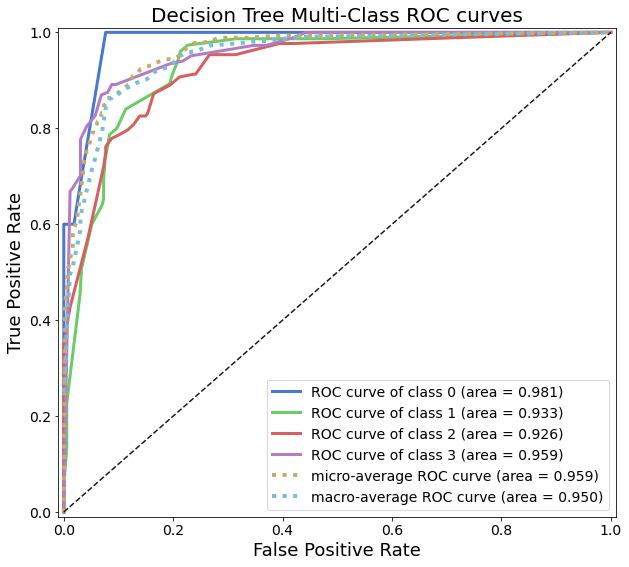

<Figure size 432x288 with 0 Axes>

In [68]:
## from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#area-under-roc-for-the-multiclass-problem
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score
from itertools import cycle
import matplotlib as mpl

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

classes=[0,1,2,3]
n_classes = len(classes)
yt_bin = label_binarize(yenc_tst, classes=classes)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(yt_bin[:,i], mod.predict_proba(Xts[fs_colnames])[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr['micro'], tpr['micro'], _ = roc_curve(yt_bin.ravel(), mod.predict_proba(Xts[fs_colnames]).ravel())
#roc_auc['micro'] = metrics.roc_auc_score(yenc_tst, predprobs_test, average='micro',multi_class='ovr')
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = metrics.roc_auc_score(yenc_tst, predprobs_test, average='macro',multi_class='ovr')
#roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
lw = 3
with mpl.style.context("seaborn-muted"):
  plt.figure(figsize=(10,9))

  colors = cycle(['#4A67BF','#8C8C8C','#73A96C','#AD5153'])
  for i, color in zip(range(n_classes), colors):
      plt.plot(fpr[i], tpr[i], lw=lw,   #color=color,lw=lw,alpha=.5,
              label='ROC curve of class {0} (area = {1:0.3f})'
              ''.format(i, roc_auc[i]))

  plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.3f})'
                  ''.format(roc_auc["micro"]),
            linestyle=':', lw=(lw+1))  #color='#C98AC1',alpha=.5

  plt.plot(fpr["macro"], tpr["macro"],
          label='macro-average ROC curve (area = {0:0.3f})'
                ''.format(roc_auc["macro"]),
           linestyle=':', lw=(lw+1))  #color='#82B3CC', lw=lw,alpha=.5
           
  plt.plot([0, 1], [0, 1], 'k--') #, lw=lw, alpha=0.5
  plt.xlim([-0.01, 1.01])
  plt.ylim([-0.01, 1.01])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Decision Tree Multi-Class ROC curves')
  plt.legend(loc="lower right")
  plt.show()
  plt.savefig(datafolder / 'DecisionTree_WDS4_ROCplot.png')

#### Grab some stats

In [69]:
from sklearn.metrics import accuracy_score

print('Training accuracy: {}'.format(accuracy_score(yenc_trn,finDTpl.predict(Xtr[fs_colnames]))))
print('Testing accuracy: {}'.format(accuracy_score(yenc_tst,finDTpl.predict(Xts[fs_colnames]))))

roctrn = roc_auc_score(yenc_trn, finDTpl.predict_proba(Xtr[fs_colnames]), multi_class='ovr')
print('AUC train: {}'.format(roctrn))
  
roctest = roc_auc_score(yenc_tst, finDTpl.predict_proba(Xts[fs_colnames]), multi_class='ovr')
print('AUC test: {}'.format(roctest))
print(best_params)

Training accuracy: 0.8664103796251802
Testing accuracy: 0.8139013452914798
AUC train: 0.9724281055423428
AUC test: 0.9498989817790062
{'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 7, 'min_samples_split': 18, 'max_features': 20, 'ccp_alpha': 0.01}


### Generate model for all data

In [71]:
# load full map dataset
with open(datafolder/ "full_shared.pkl","rb") as handle: 
    datadict = pkl.load(handle)
    
# unpack
FULLdf     = datadict['data']
FULLcoords = datadict['coords']

pfa_result = FULLdf['GeothermGrad_4class']
FULLdf = FULLdf[colnames]

# refit final pipeline on all data
Xall   = pd.concat([Xtr,Xvl,Xts])
yenc_all=np.append(np.append(yenc_trn,yenc_val),yenc_tst)

mod_all = DecisionTreeClassifier(criterion=best_params['criterion'],
                                 max_depth=best_params['max_depth'],
                                 min_samples_leaf=best_params['min_samples_leaf'],
                                 min_samples_split=best_params['min_samples_split'],
                                 max_features=best_params['max_features'],
                                 ccp_alpha=best_params['ccp_alpha'],
                                 random_state=seed)
# as noted earlier, StandardScaler and PowerTransformer both used to standardize
# to overcome bug that reduces 2 features to single values
sc = StandardScaler()
pt = PowerTransformer(method='yeo-johnson', standardize=True)
mod_all = Pipeline(steps=[('scale',sc),('powertransform',pt),('dt',mod_all)])
mod_all.fit(Xall[fs_colnames], yenc_all);

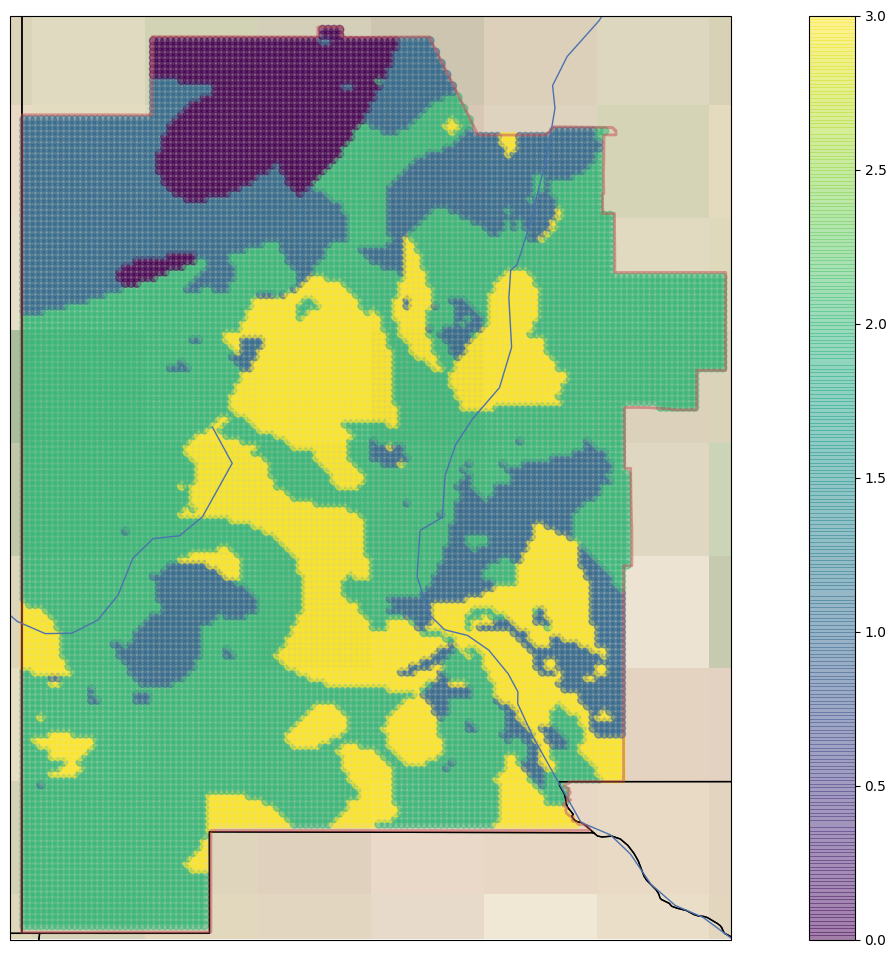

In [72]:
import matplotlib as mpl 
# predict result
FULL_ypred = mod_all.predict(FULLdf[fs_colnames])
FULL_ypred_proba = mod_all.predict_proba(FULLdf[fs_colnames])

# plot result
with mpl.style.context('default'):
  ax = createBasemap();
  gdf = gpd.GeoDataFrame(FULLcoords, 
                        geometry=gpd.points_from_xy(FULLcoords.Longitude, FULLcoords.Latitude),
                        crs = {'init': 'epsg:4326'})
  pc = ax.scatter(FULLcoords.Longitude,
                  FULLcoords.Latitude,
                  c=FULL_ypred,
                  cmap='viridis',
                  alpha=0.5,
                  transform=myprojection);
  plt.colorbar(pc);
  plt.savefig(datafolder / 'decisiontree_model_prediction_map.png')
  plt.savefig(datafolder / 'decisiontree_model_prediction_map.pdf')

In [73]:
# save out for use in other scripts
shared = {
          "coords":FULLcoords,
          "model":mod_all,
          "full_dataset":FULLdf,
          "selected_columns":fs_colnames,
          "test_yc_pred":preds_test,
          "test_yc_pred_proba":predprobs_test,
          "full_yc_pred":FULL_ypred,
          "full_yc_pred_proba":FULL_ypred_proba
         }
with open(datafolder / "gradient_class_prediction_dtree.pkl","wb") as handle:
    pkl.dump(shared, handle, protocol=pkl.HIGHEST_PROTOCOL)

### plot text version of decision tree

In [74]:
!pip install -q dtreeviz
%matplotlib inline
from dtreeviz.trees import dtreeviz
from dtreeviz.utils import extract_params_from_pipeline
from PIL import Image

     |████████████████████████████████| 62 kB 612 kB/s 


In [75]:
# Print the tuned parameters and score
print("Final Decision Tree Parameters: {}".format(mod_all.get_params()))
print("Train score is {}".format(roc_auc_score(yenc_trn,mod.predict_proba(Xtr[fs_colnames]),multi_class='ovr')))
print("Validation score is {}".format(roc_auc_score(yenc_val,mod.predict_proba(Xvl[fs_colnames]),multi_class='ovr')))
print("Test score is {}".format(roc_auc_score(yenc_tst,mod.predict_proba(Xts[fs_colnames]),multi_class='ovr')))

Final Decision Tree Parameters: {'memory': None, 'steps': [('scale', StandardScaler()), ('powertransform', PowerTransformer()), ('dt', DecisionTreeClassifier(ccp_alpha=0.01, criterion='entropy', max_depth=9,
                       max_features=20, min_samples_leaf=7,
                       min_samples_split=18, random_state=43))], 'verbose': False, 'scale': StandardScaler(), 'powertransform': PowerTransformer(), 'dt': DecisionTreeClassifier(ccp_alpha=0.01, criterion='entropy', max_depth=9,
                       max_features=20, min_samples_leaf=7,
                       min_samples_split=18, random_state=43), 'scale__copy': True, 'scale__with_mean': True, 'scale__with_std': True, 'powertransform__copy': True, 'powertransform__method': 'yeo-johnson', 'powertransform__standardize': True, 'dt__ccp_alpha': 0.01, 'dt__class_weight': None, 'dt__criterion': 'entropy', 'dt__max_depth': 9, 'dt__max_features': 20, 'dt__max_leaf_nodes': None, 'dt__min_impurity_decrease': 0.0, 'dt__min_samples_le

In [77]:
text_representation = tree.export_text(mod_all.named_steps.dt,max_depth=5,feature_names=fs_colnames)
print(text_representation)

|--- SiGeothermometry <= -0.34
|   |--- CrustalThickness <= 1.80
|   |   |--- Vents <= 0.58
|   |   |   |--- HeatFlow <= 0.52
|   |   |   |   |--- Springs <= 1.30
|   |   |   |   |   |--- StrainRate <= 1.67
|   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |--- StrainRate >  1.67
|   |   |   |   |   |   |--- class: 2
|   |   |   |   |--- Springs >  1.30
|   |   |   |   |   |--- Drainage <= 1.19
|   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |--- Drainage >  1.19
|   |   |   |   |   |   |--- class: 3
|   |   |   |--- HeatFlow >  0.52
|   |   |   |   |--- VolcanicDikes <= 0.51
|   |   |   |   |   |--- BasementDepth <= -1.14
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- BasementDepth >  -1.14
|   |   |   |   |   |   |--- class: 3
|   |   |   |   |--- VolcanicDikes >  0.51
|   |   |   |   |   |--- Springs <= 0.05
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- Springs >  0.05
|   |   |   |   |   |   |-

### Plot Decision Tree


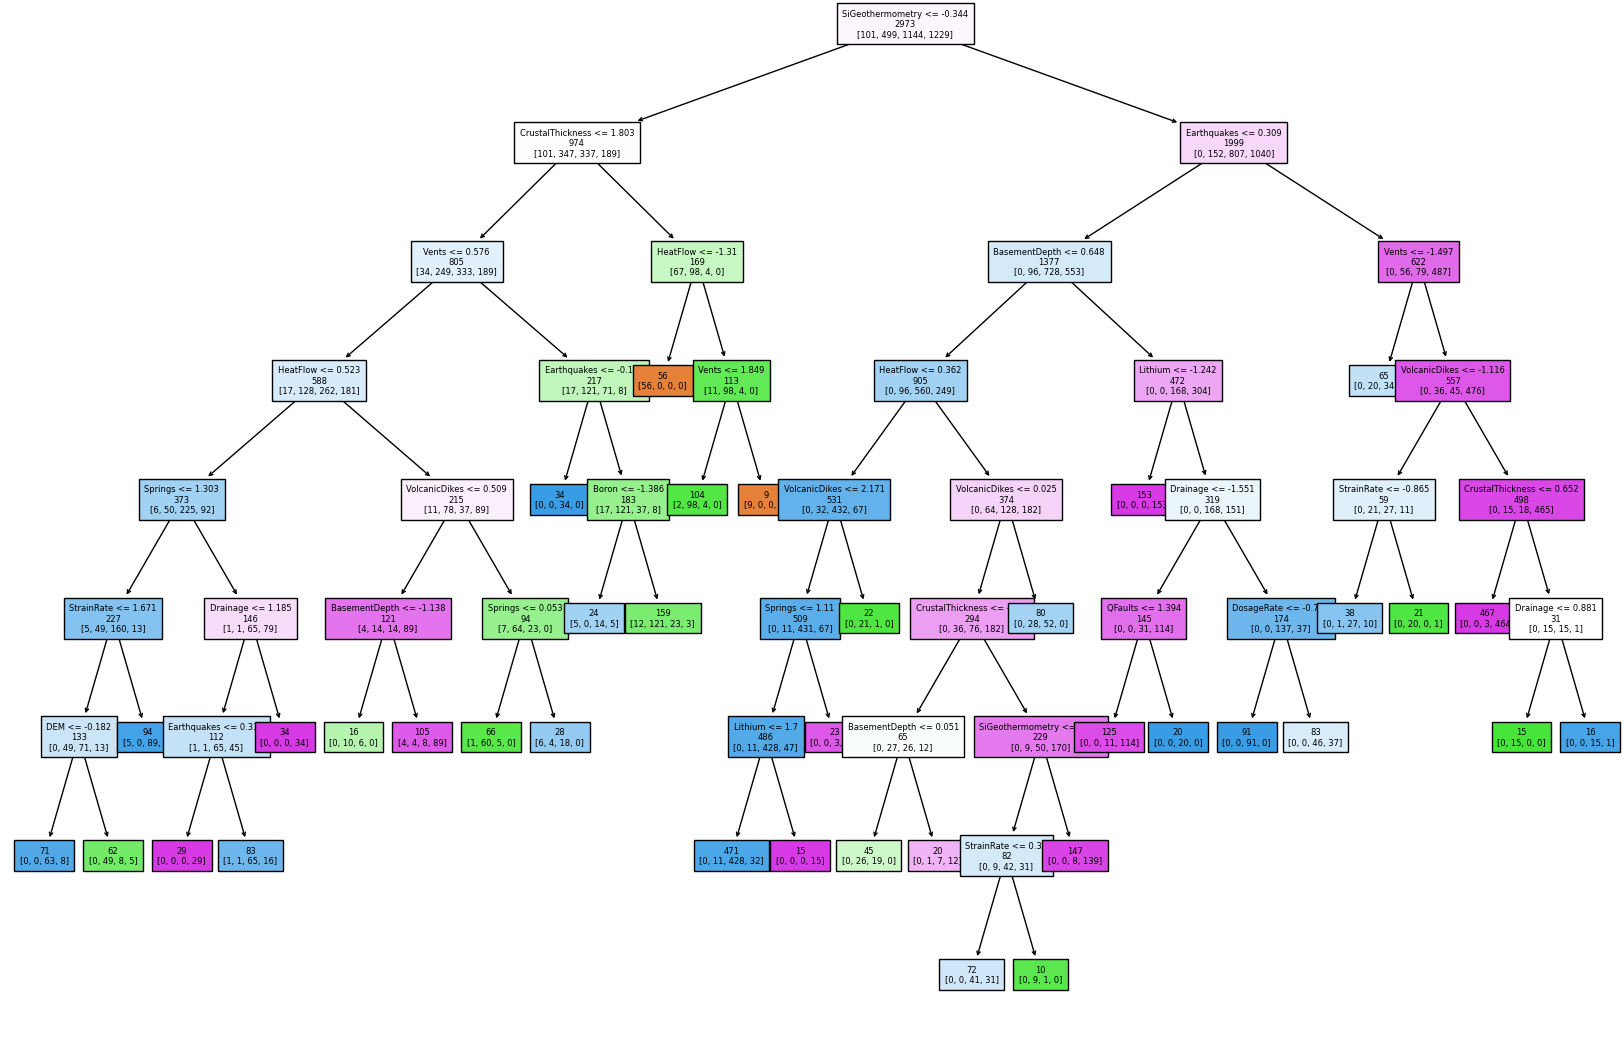

In [79]:
import itertools

with mpl.style.context('default'):
  fig = plt.figure(figsize=(15,10))
  tree.plot_tree(mod_all.named_steps.dt,
                max_depth=8, 
                fontsize=6, 
                feature_names=fs_colnames, 
                label='none',
                impurity=False, 
                filled=True, 
                proportion=False); 
  fig.savefig(datafolder / "DecisionTreeFull.png")

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


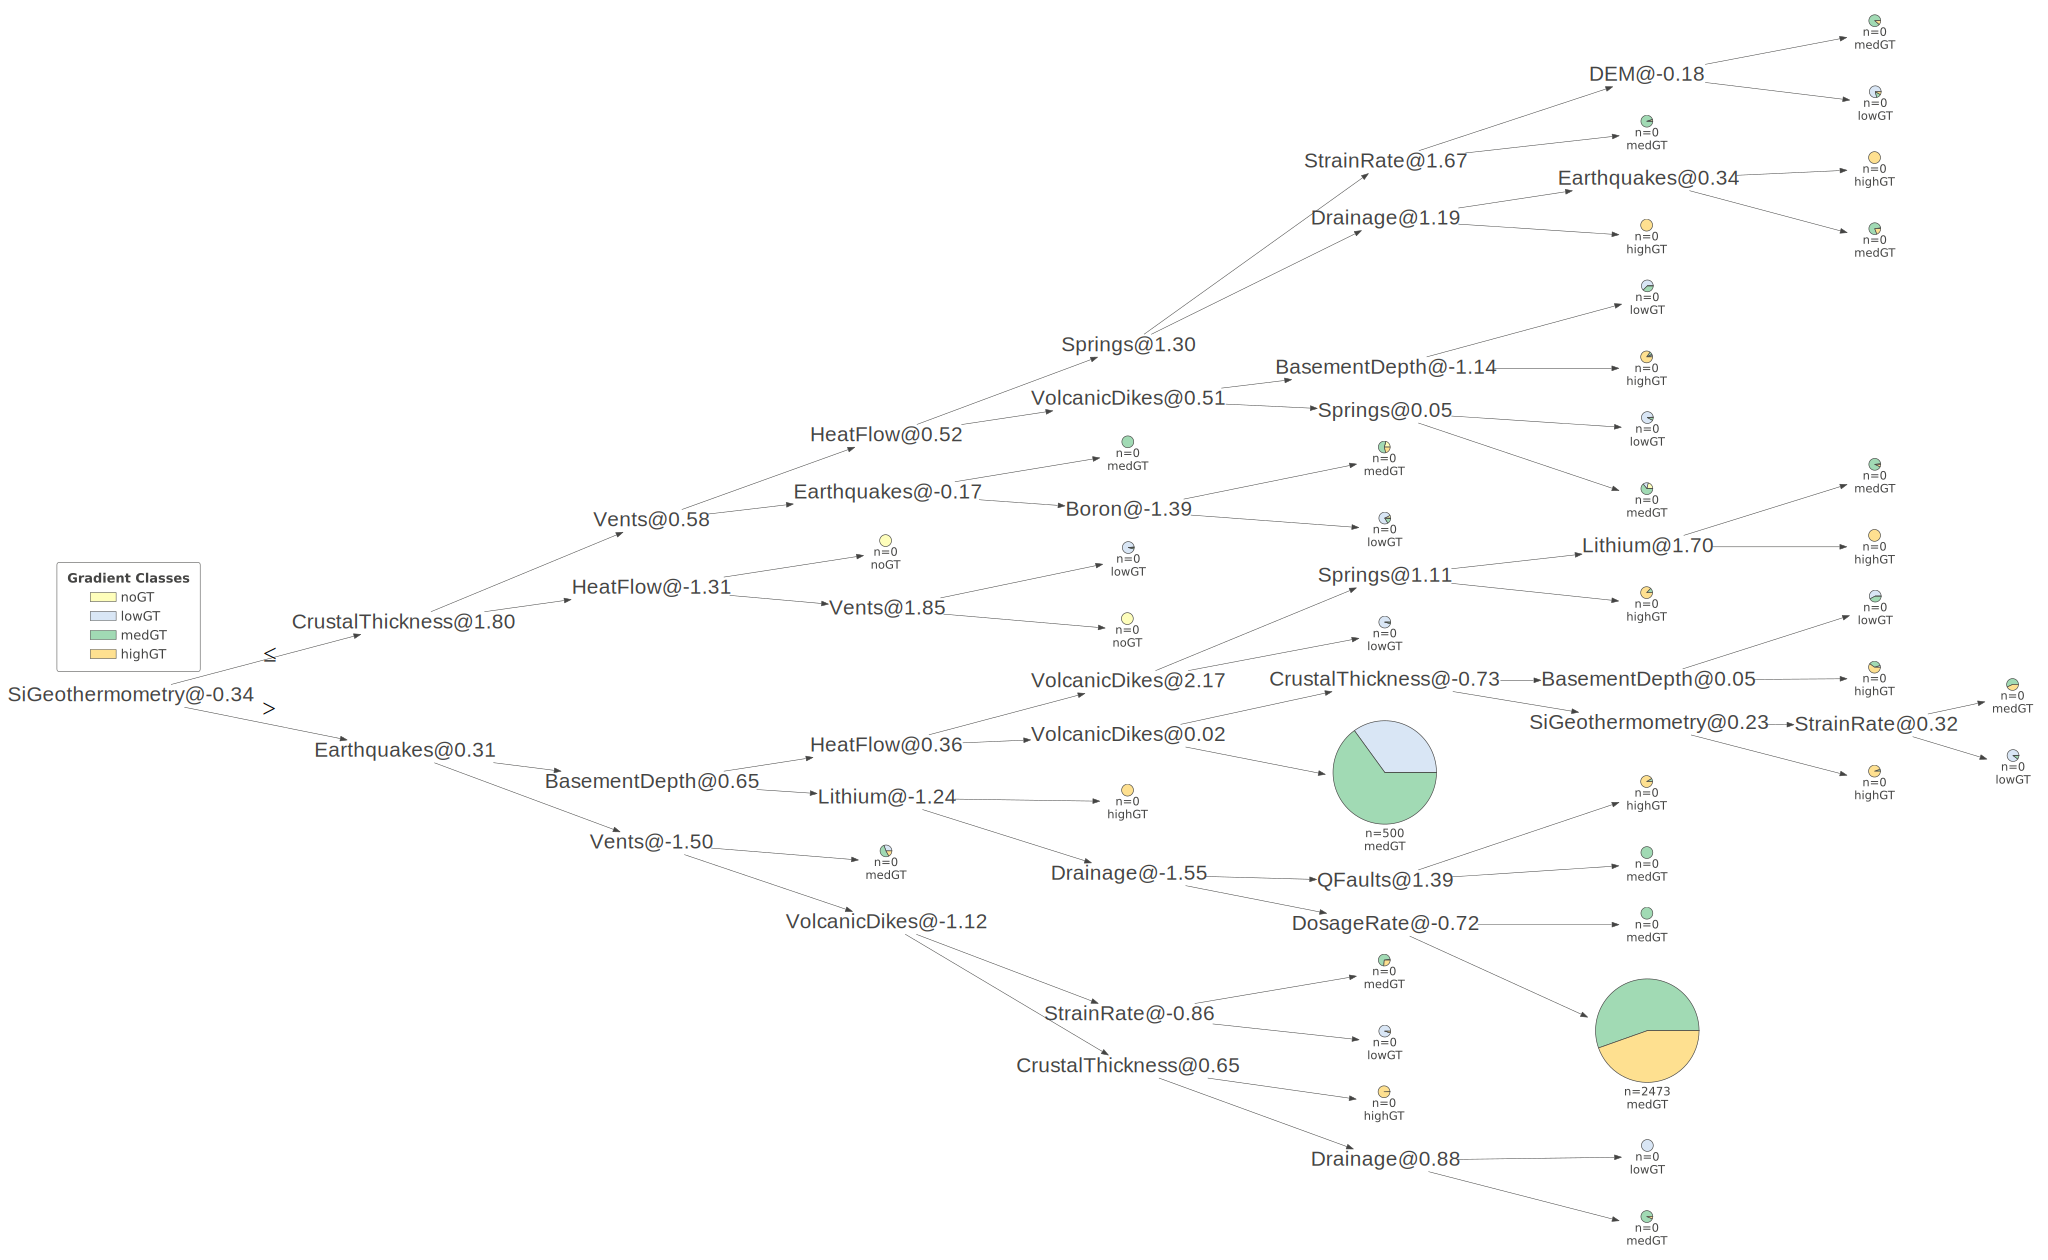

In [80]:
with mpl.style.context('default'):
  viz = dtreeviz(mod_all.named_steps.dt,
                Xall[fs_colnames],
                yenc_all,
                fancy=False,
                orientation='LR',
                scale=2,
                fontname="Arial",
                feature_names=fs_colnames,
                class_names=['noGT','lowGT', 'medGT','highGT'],
                title_fontsize=16,
                target_name="Gradient Classes")
#viz.view()

vizfile = datafolder / 'dtreeviz_fulldata.svg'
viz.save(str(vizfile))
viz